# Fraud Detection in Bitcoin Networks: A Machine Learning Approach with the EllipticPlusPlus Dataset

------

#### Team Members
- Austin Yeh
- Haoxiang Yi
- Muhammad Ibrahim
- Luke Leon
- Biagio Alessandrello


#### Import libraries

In [1]:
import os
import multiprocessing as mp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score, classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import tensorflow as tf
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")

## Part 1: Datasets and EDA

### Get all the files

In [3]:
folder_path = 'elliptic_plus'

for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        dataframe_name = os.path.splitext(file_name)[0]
        file_path = os.path.join(folder_path, file_name)
        globals()[dataframe_name] = pd.read_csv(file_path)
        print(f"{dataframe_name}, Shape: {globals()[dataframe_name].shape}")


AddrTx_edgelist, Shape: (477117, 2)
txs_edgelist, Shape: (234355, 2)
txs_features, Shape: (203769, 184)
AddrAddr_edgelist, Shape: (2868964, 2)
TxAddr_edgelist, Shape: (837124, 2)
wallets_features_classes_combined, Shape: (1268260, 58)
txs_classes, Shape: (203769, 2)
wallets_classes, Shape: (822942, 2)
wallets_features, Shape: (1268260, 57)


### Datasets Arrangement

Transactions

In [5]:
# Merge txs_classes and txs_features
df_transactions = txs_features.merge(txs_classes, on='txId')
print("Class split: ", df_transactions.groupby('class').size())

# Sort the DataFrame by 'timestep'
df_transactions = df_transactions.sort_values(by='Time step').dropna()
print("df_transactions shape: ", df_transactions.shape)

Class split:  class
1      4545
2     42019
3    157205
dtype: int64
df_transactions shape:  (202804, 185)


In [7]:
df_transactions

,txId,Time step,Local_feature_1,Local_feature_2,Local_feature_3,Local_feature_4,Local_feature_5,Local_feature_6,Local_feature_7,Local_feature_8,...,in_BTC_max,in_BTC_mean,in_BTC_median,in_BTC_total,out_BTC_min,out_BTC_max,out_BTC_mean,out_BTC_median,out_BTC_total,class
0,3321,1,-0.169615,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.160199,...,0.534072,0.534072,0.534072,0.534072,0.166899,0.367074,0.266986,0.266986,0.533972,3
5261,230644286,1,-0.168016,-0.210553,-1.756361,1.303743,-0.063725,0.809483,0.242712,-0.163643,...,0.088815,0.039374,0.036976,0.787487,0.787487,0.787487,0.787487,0.787487,0.787487,2
5260,230644270,1,-0.172216,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162861,...,0.121672,0.121672,0.121672,0.121672,0.001754,0.119818,0.060786,0.060786,0.121572,3
5259,230643780,1,6.891495,-0.202401,0.463609,-0.121970,-0.043875,-0.113002,-0.061584,7.064357,...,1119.999684,1119.999684,1119.999684,1119.999684,100.000000,1019.999652,559.999826,559.999826,1119.999652,3
5258,230643592,1,0.085544,-0.184668,-1.201369,-0.046932,-0.043875,-0.029140,-0.061584,-0.163646,...,40.986780,20.493402,20.493402,40.986803,0.986803,39.999900,20.493352,20.493352,40.986703,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201494,158343950,49,-0.170947,-0.150297,1.018602,-0.121970,-0.043875,-0.113002,-0.061584,-0.161562,...,0.322945,0.322945,0.322945,0.322945,0.033986,0.288727,0.161356,0.161356,0.322712,3
201495,158344134,49,-0.168172,-0.110838,1.018602,-0.046932,-0.043875,-0.029140,-0.061584,-0.161205,...,0.384832,0.381498,0.381498,0.762995,0.353489,0.409121,0.381305,0.381305,0.762610,3
201496,158344182,49,-0.172185,-0.110838,1.018602,-0.046932,-0.043875,-0.113002,0.242712,-0.163366,...,0.083580,0.063452,0.063452,0.126905,0.013244,0.113275,0.063260,0.063260,0.126519,3
201497,158344627,49,-0.172852,-0.150297,1.018602,-0.121970,-0.043875,-0.113002,-0.061584,-0.163511,...,0.020900,0.020900,0.020900,0.020900,0.006571,0.014097,0.010334,0.010334,0.020667,3


EDA of the transactions counted over time

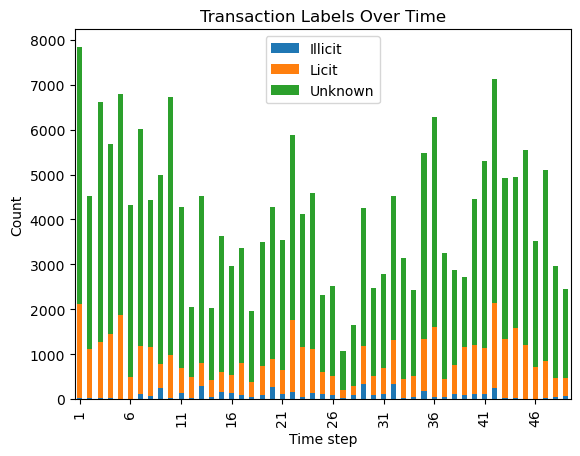

In [9]:
ay = df_transactions.groupby(['Time step', 'class']).size().unstack().plot(kind='bar', stacked=True)
plt.xlabel('Time step')
plt.xticks(ticks=range(0, df_transactions['Time step'].max() + 1, 5))
plt.ylabel('Count')
plt.title('Transaction Labels Over Time')
ay.legend(['Illicit', 'Licit', 'Unknown'])
plt.show()

EDA of the wallets counted over time

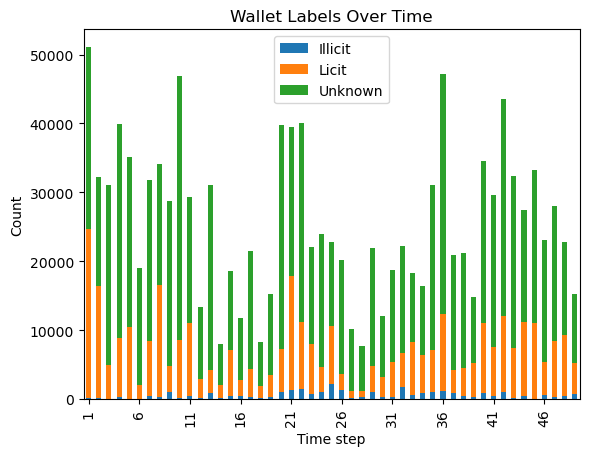

In [11]:
ax = wallets_features_classes_combined.groupby(['Time step', 'class']).size().unstack().plot(kind='bar', stacked=True)
plt.xlabel('Time step')
plt.xticks(ticks=range(0, df_transactions['Time step'].max() + 1, 5))
plt.ylabel('Count')
plt.title('Wallet Labels Over Time')
ax.legend(['Illicit', 'Licit', 'Unknown'])  # Change the class labels here
plt.show()

Final Holdout Dataset: Labeled transactions

In [13]:
df_transactions_45_49 = df_transactions[(df_transactions['Time step'] >= 45) & (df_transactions['class'] != 3)]
print("df_transactions_45_49 shape: ", df_transactions_45_49.shape)

df_transactions_45_49 shape:  (3692, 185)


Datasets for semi-supervised learning

In [15]:
df_transactions_1_44 = df_transactions[df_transactions['Time step'] <= 44]
print("df_transactions_1_44 shape: ", df_transactions_1_44.shape)

# 1. For choosing model using the labeled data
df_transactions_1_44_labeled = df_transactions_1_44[df_transactions_1_44['class'] != 3]
df_transactions_1_44_labeled = df_transactions_1_44_labeled.sort_values(by='Time step')
print("df_transactions_1_44_labeled shape: ", df_transactions_1_44_labeled.shape)

# Identify the cutoff for 70/30 split and split based on the Time step
total_time_steps = 44
train_cutoff = int(total_time_steps * 0.7)  # 70% for training
train_data = df_transactions_1_44_labeled[df_transactions_1_44_labeled['Time step'] <= train_cutoff]
test_data = df_transactions_1_44_labeled[df_transactions_1_44_labeled['Time step'] > train_cutoff]

# Separate features and labels for train and test sets
df_transactions_1_44_labeled_X_train = train_data.drop(columns=['class'])
df_transactions_1_44_labeled_y_train = train_data['class']
df_transactions_1_44_labeled_X_test = test_data.drop(columns=['class'])
df_transactions_1_44_labeled_y_test = test_data['class']
print("df_transactions_1_44_labeled_X_train shape: ", df_transactions_1_44_labeled_X_train.shape)
print("df_transactions_1_44_labeled_X_test shape: ", df_transactions_1_44_labeled_X_test.shape)
print("df_transactions_1_44_labeled_y_train shape: ", df_transactions_1_44_labeled_y_train.shape)
print("df_transactions_1_44_labeled_y_test shape: ", df_transactions_1_44_labeled_y_test.shape)

# 2. For labeling the unlabeled dataset
df_transactions_1_44_unlabeled = df_transactions_1_44[df_transactions_1_44['class'] == 3]
print("df_transactions_1_44_unlabeled shape: ", df_transactions_1_44_unlabeled.shape)
df_transactions_1_44_unlabeled_X_test = df_transactions_1_44_unlabeled.drop(columns = 'class')
df_transactions_1_44_unlabeled_y_test = df_transactions_1_44_unlabeled['class']

df_transactions_1_44 shape:  (183227, 185)
df_transactions_1_44_labeled shape:  (42353, 185)
df_transactions_1_44_labeled_X_train shape:  (26750, 184)
df_transactions_1_44_labeled_X_test shape:  (15603, 184)
df_transactions_1_44_labeled_y_train shape:  (26750,)
df_transactions_1_44_labeled_y_test shape:  (15603,)
df_transactions_1_44_unlabeled shape:  (140874, 185)


Datasets for unsupervised learning of wallet risk scores

In [17]:
df_wallets = wallets_features.sort_values(by='Time step').dropna() 
print("df_wallets shape: ", df_wallets.shape)

df_wallets_1_10 = df_wallets[df_wallets['Time step'] <= 10]
df_wallets_1_10.drop_duplicates(subset='address', keep='first', inplace=True)
print("df_wallets_1_10 deduped shape: ", df_wallets_1_10.shape)

df_wallets shape:  (1268260, 57)
df_wallets_1_10 shape:  (349941, 57)
df_wallets_1_10 deduped shape:  (220639, 57)


## Part 2: Modeling

### 2.1: Unsupervised Learning for Customer Wallet Risk Clusters

In [19]:
# Drop non-numeric column "address" (used as the identifier)
address_col = df_wallets_1_10["address"]
data = df_wallets_1_10.drop(columns=["address","Time step"])

# Standardize the Data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Apply K-Means Clustering
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
data['cluster'] = kmeans.fit_predict(data_scaled)

# Store the scores into final dataframe
df_wallet_scores = pd.DataFrame({"address": address_col, "score": data['cluster']
})

df_wallet_scores.to_csv("wallet_scores.csv")

Use the KMeans model above to classify all wallet addresses

In [21]:
new_data = df_wallets.drop(columns=['address', 'Time step'])
new_data_scaled = scaler.transform(new_data)

new_data['cluster'] = kmeans.predict(new_data_scaled)
new_data['cluster'].value_counts()

df_wallet_scores_full = pd.DataFrame({"address": df_wallets['address'], "score": new_data['cluster']}).drop_duplicates()
df_wallet_scores_full.to_csv("wallet_scores_full.csv", index=False)

#### Plotting using T-SNE

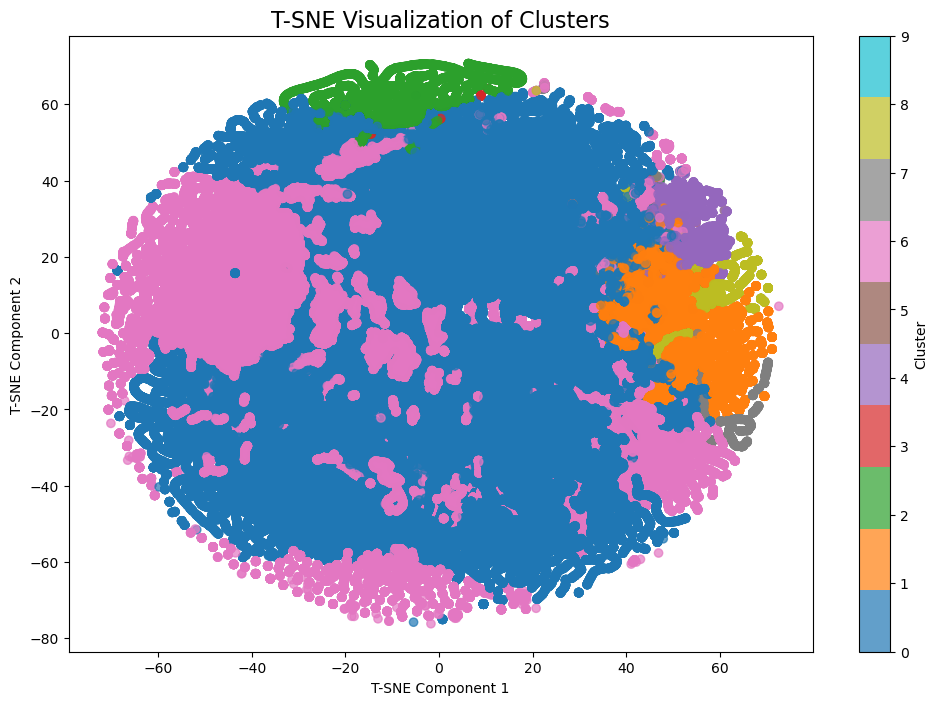

In [19]:
tsne = TSNE(n_components=2, perplexity=10, random_state=42, n_iter=500)
data_tsne = tsne.fit_transform(data_scaled)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=data['cluster'], cmap='tab10', alpha=0.7)
plt.colorbar(scatter, label='Cluster')
plt.title("T-SNE Visualization of Clusters", fontsize=16)
plt.xlabel("T-SNE Component 1")
plt.ylabel("T-SNE Component 2")
plt.show()

#### Check fraud not fraud composition in each group

In [23]:
# Merging the wallet scores with the wallet classes, filling the NA values with 3 (unknown)
df_wallet_score_class = pd.merge(df_wallet_scores, wallets_classes, on="address", how="left")
df_wallet_score_class['class'] = df_wallet_score_class['class'].fillna(3).astype(int)

# Grouping by the score and calculating the percentage of each class
df_wallet_score_class.groupby('score').apply(lambda x: pd.Series({
        'fraud_percentage': (x['class'] == 1).sum() / len(x) * 100,
        'not_fraud_percentage': (x['class'] == 2).sum() / len(x) * 100,
        'unknown_percentage': (x['class'] == 3).sum() / len(x) * 100,
    })).reset_index()

,score,fraud_percentage,not_fraud_percentage,unknown_percentage
0,0,0.465113,32.392712,67.142175
1,1,0.341815,29.044816,70.613369
2,2,0.000000,0.996441,99.003559
3,3,0.000000,2.000000,98.000000
4,4,0.202156,26.212938,73.584906
5,5,0.000000,83.333333,16.666667
6,6,0.994546,49.510748,49.494706
7,7,0.264901,1.456954,98.278146
8,8,0.065876,90.513834,9.420290
9,9,0.000000,100.000000,0.000000


In [25]:
# Grouping by the score and calculating the percentage of fraud
df_wallet_score_class.groupby('score').apply(lambda x: pd.Series({
        'fraud_percentage': (x['class'] == 1).sum() / len(x) * 100
    })).reset_index().sort_values('score', ascending=False)

,score,fraud_percentage
9,9,0.000000
8,8,0.065876
7,7,0.264901
6,6,0.994546
5,5,0.000000
4,4,0.202156
3,3,0.000000
2,2,0.000000
1,1,0.341815
0,0,0.465113


### 2.2: Labeling the Unlabeled TX data

#### Random Forrest performance

Performance Metrics:
Accuracy: 0.98
Precision: 0.96
Recall: 0.86
F1-Score: 0.91


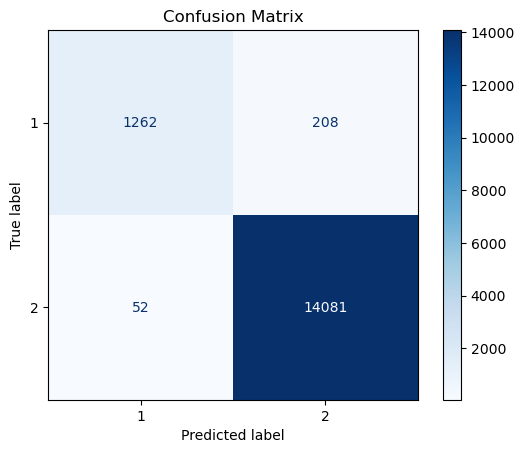

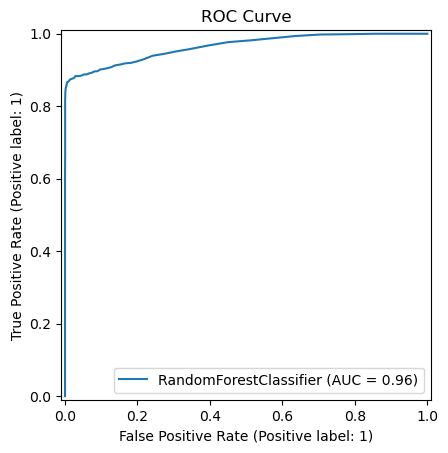

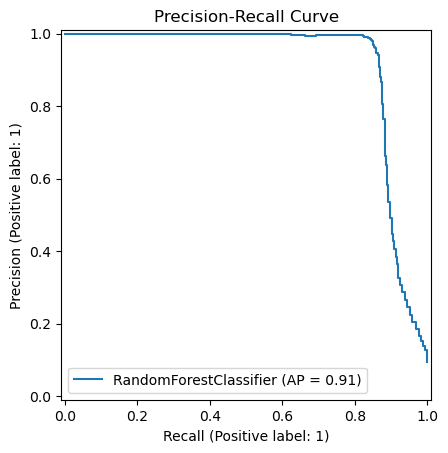

In [27]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(df_transactions_1_44_labeled_X_train, df_transactions_1_44_labeled_y_train)

y_pred = rf_model.predict(df_transactions_1_44_labeled_X_test)
accuracy = accuracy_score(df_transactions_1_44_labeled_y_test, y_pred)
precision = precision_score(df_transactions_1_44_labeled_y_test, y_pred)
recall = recall_score(df_transactions_1_44_labeled_y_test, y_pred)
f1 = f1_score(df_transactions_1_44_labeled_y_test, y_pred)

print("Performance Metrics:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

cm = confusion_matrix(df_transactions_1_44_labeled_y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

disp = RocCurveDisplay.from_estimator(rf_model, df_transactions_1_44_labeled_X_test, df_transactions_1_44_labeled_y_test, pos_label=1)
plt.title("ROC Curve")
plt.show()

disp = PrecisionRecallDisplay.from_estimator(rf_model, df_transactions_1_44_labeled_X_test, df_transactions_1_44_labeled_y_test, pos_label=1)
plt.title("Precision-Recall Curve")
plt.show()

#### XGBOOST performance

Performance Metrics:
Accuracy: 0.98
Precision: 0.98
Recall: 0.99
F1-Score: 0.99


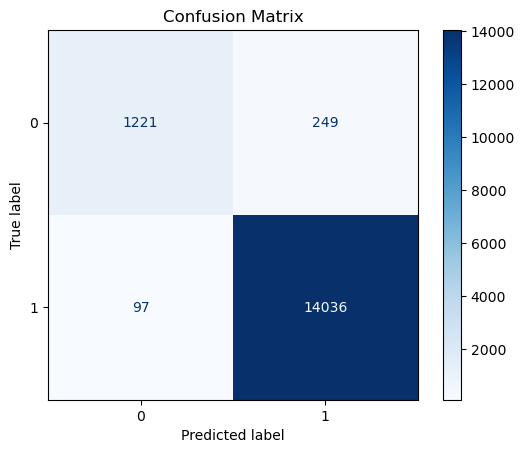

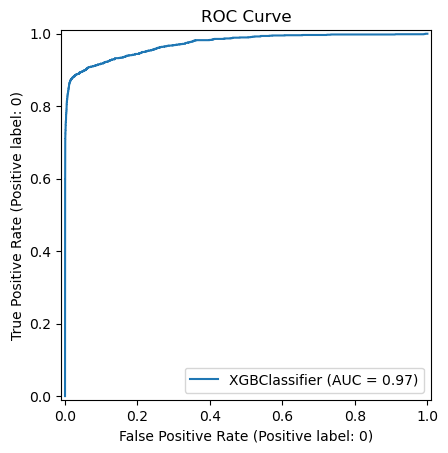

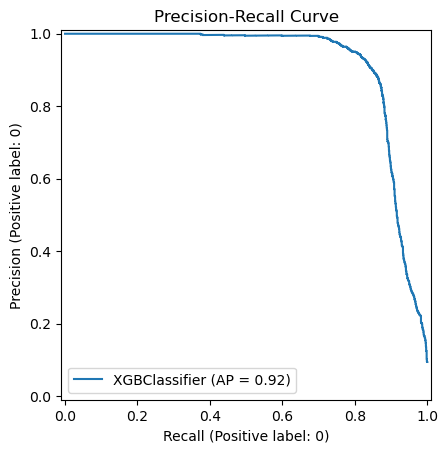

In [23]:
df_transactions_1_44_labeled_y_train_xgb = df_transactions_1_44_labeled_y_train.replace({1: 0, 2: 1})
df_transactions_1_44_labeled_y_test_xgb = df_transactions_1_44_labeled_y_test.replace({1: 0, 2: 1})

xgb_model = XGBClassifier(n_estimators=100, random_state=42)
xgb_model.fit(df_transactions_1_44_labeled_X_train, df_transactions_1_44_labeled_y_train_xgb)

y_pred = xgb_model.predict(df_transactions_1_44_labeled_X_test)
accuracy = accuracy_score(df_transactions_1_44_labeled_y_test_xgb, y_pred)
precision = precision_score(df_transactions_1_44_labeled_y_test_xgb, y_pred)
recall = recall_score(df_transactions_1_44_labeled_y_test_xgb, y_pred)
f1 = f1_score(df_transactions_1_44_labeled_y_test_xgb, y_pred)
print("Performance Metrics:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

cm = confusion_matrix(df_transactions_1_44_labeled_y_test_xgb, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_model.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

disp = RocCurveDisplay.from_estimator(xgb_model, df_transactions_1_44_labeled_X_test, df_transactions_1_44_labeled_y_test_xgb, pos_label=0)
plt.title("ROC Curve")
plt.show()

disp = PrecisionRecallDisplay.from_estimator(xgb_model, df_transactions_1_44_labeled_X_test, df_transactions_1_44_labeled_y_test_xgb, pos_label=0)
plt.title("Precision-Recall Curve")
plt.show()

#### Now using model to predict the labels for the unknown class

In [30]:
df_transactions_1_44_unlabeled['class'] = rf_model.predict(df_transactions_1_44_unlabeled_X_test)
df_transactions_1_44_unlabeled.groupby('class').size()

class
1      9050
2    131824
dtype: int64

### 2.3: Final Model

#### Make final dataset for re-training

In [32]:
# Merge labeled and predicted labeled data
df_transactions_1_44_binary_class = pd.concat([df_transactions_1_44_labeled, df_transactions_1_44_unlabeled], axis=0)

# Display the distribution of the classes
class_counts = df_transactions_1_44_binary_class.groupby('class').size()
class_percentages = (class_counts / class_counts.sum()) * 100
pd.DataFrame({"Count": class_counts,"Percentage": class_percentages})

,Count,Percentage
class,,
1,13474,7.35372
2,169753,92.64628


In [34]:
# Combine input and output addresses on a transaction
TxAddr_mapping = pd.merge(AddrTx_edgelist, TxAddr_edgelist, on="txId", how="outer")

# Merge on 'input_address' with 'address' from df_wallet_scores
TxAddr_mapping = pd.merge(TxAddr_mapping, df_wallet_scores_full, left_on='input_address', right_on='address', how='left')
TxAddr_mapping.rename(columns={'score': 'input_wallet_score'}, inplace=True)
TxAddr_mapping.drop(columns=['address'], inplace=True)

# Merge on 'output_address' with 'address' from df_wallet_scores
TxAddr_mapping = pd.merge(TxAddr_mapping, df_wallet_scores_full, left_on='output_address', right_on='address', how='left')
TxAddr_mapping.rename(columns={'score': 'output_wallet_score'}, inplace=True)
TxAddr_mapping.drop(columns=['address'], inplace=True)
TxAddr_mapping

# Perform a left join to add the input_wallet_score and output_wallet_score columns
df_transactions_1_44_binary_class = pd.merge(
    df_transactions_1_44_binary_class, TxAddr_mapping[['txId', 'input_wallet_score', 'output_wallet_score']],on='txId',how='left'
)

# Removing information leak
df_transactions_11_44_binary_class = df_transactions_1_44_binary_class[df_transactions_1_44_binary_class['Time step'] >= 11]

Percentage of each wallet cluster for input and output addresses

In [36]:
input_counts = (df_transactions_11_44_binary_class.groupby('input_wallet_score', dropna=False).size().reset_index(name='input_composition'))
total_input = input_counts['input_composition'].sum()
input_counts['input_composition'] = (input_counts['input_composition'] / total_input) * 100

output_counts = (df_transactions_11_44_binary_class.groupby('output_wallet_score', dropna=False).size().reset_index(name='output_composition'))
total_output = output_counts['output_composition'].sum()
output_counts['output_composition'] = (output_counts['output_composition'] / total_output) * 100

score_composition = pd.merge(input_counts, output_counts, left_on='input_wallet_score', right_on='output_wallet_score', how='outer', suffixes=('_input', '_output'))
score_composition

,input_wallet_score,input_composition,output_wallet_score,output_composition
0,0,15.388204,0,54.284465
1,1,2.779021,1,9.865651
2,2,0.817677,2,0.669073
3,3,0.071572,3,0.016498
4,4,4.483276,4,2.045023
5,5,1.604434,5,1.145982
6,6,59.725771,6,20.726604
7,7,14.220026,7,10.777926
8,8,0.036439,8,0.468600
9,9,0.873581,9,0.000178


In [38]:
df_transactions_45_49 = pd.merge(
    df_transactions_45_49, TxAddr_mapping[['txId', 'input_wallet_score', 'output_wallet_score']],on='txId',how='left'
)

#### De-duping the wallet scores

In [40]:
# Merging the wallet scores with the transactions and removing the duplicated items due to different input and output wallet scores for the same transaction for time steps 11-44
df_transactions_11_44_binary_class = df_transactions_11_44_binary_class.merge(
    df_transactions_11_44_binary_class.groupby(['txId', 'Time step']).agg({'input_wallet_score': lambda x: x.mode()[0], 'output_wallet_score': lambda x: x.mode()[0]}),
    on=['txId', 'Time step'],
    how='right'
).drop(columns=['input_wallet_score_x', 'output_wallet_score_x']).drop_duplicates().rename(columns={'input_wallet_score_y': 'input_wallet_score', 'output_wallet_score_y': 'output_wallet_score'}).reset_index().drop(['index'], axis=1)

df_transactions_11_44_binary_class

,txId,Time step,Local_feature_1,Local_feature_2,Local_feature_3,Local_feature_4,Local_feature_5,Local_feature_6,Local_feature_7,Local_feature_8,...,in_BTC_median,in_BTC_total,out_BTC_min,out_BTC_max,out_BTC_mean,out_BTC_median,out_BTC_total,class,input_wallet_score,output_wallet_score
0,3181,34,1.305212,-0.210553,-1.756361,-0.121970,97.300650,-0.113002,-0.061584,1.348765,...,234.352363,234.352363,0.001019,2.749248,0.047769,0.015075,234.352363,2,9,1
1,11597,11,0.177903,-0.102780,1.018602,-0.121970,0.253876,-0.113002,-0.061584,0.195364,...,55.629617,55.629617,0.006800,13.492714,3.272306,1.055371,55.629201,2,0,0
2,18589,11,-0.172415,2.181390,1.573595,-0.121970,35.825121,-0.113002,-0.061584,-0.163005,...,0.099290,0.099290,0.000010,0.030014,0.000050,0.000024,0.090050,2,7,0
3,32496,11,-0.169441,0.213110,1.573595,0.103143,9.861288,0.138585,-0.061584,-0.163639,...,0.032910,0.563106,0.000533,0.010191,0.001121,0.000819,0.561470,2,6,0
4,52635,29,-0.172544,-0.068081,0.463609,-0.046932,-0.024025,-0.029140,-0.061584,-0.163549,...,0.035012,0.070024,0.003159,0.052391,0.023158,0.013924,0.069474,2,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125235,403203785,28,-0.172978,-0.172527,0.463609,-0.121970,-0.043875,-0.113002,-0.061584,-0.163640,...,0.000853,0.000853,0.000106,0.000600,0.000353,0.000353,0.000706,2,6,0
125236,403234712,28,-0.172669,-0.158783,-1.201369,-0.121970,-0.063725,-0.113002,-0.061584,-0.163323,...,0.050000,0.050000,0.049800,0.049800,0.049800,0.049800,0.049800,1,0,0
125237,403234715,28,-0.172669,-0.158783,-1.201369,-0.121970,-0.063725,-0.113002,-0.061584,-0.163323,...,0.050000,0.050000,0.049800,0.049800,0.049800,0.049800,0.049800,1,0,0
125238,403235564,28,-0.172669,-0.158783,-1.201369,-0.121970,-0.063725,-0.113002,-0.061584,-0.163323,...,0.050000,0.050000,0.049800,0.049800,0.049800,0.049800,0.049800,1,0,0


In [41]:
# Merging the wallet scores with the transactions and removing the duplicated items due to different input and output wallet scores for the same transaction for time steps 45-49
df_transactions_45_49 = df_transactions_45_49.merge(
    df_transactions_45_49.groupby(['txId', 'Time step']).agg({'input_wallet_score': lambda x: x.mode()[0], 'output_wallet_score': lambda x: x.mode()[0]}),
    on=['txId', 'Time step'],
    how='right'
).drop(columns=['input_wallet_score_x', 'output_wallet_score_x']).drop_duplicates().rename(columns={'input_wallet_score_y': 'input_wallet_score', 'output_wallet_score_y': 'output_wallet_score'}).reset_index().drop(['index'], axis=1)

df_transactions_45_49

,txId,Time step,Local_feature_1,Local_feature_2,Local_feature_3,Local_feature_4,Local_feature_5,Local_feature_6,Local_feature_7,Local_feature_8,...,in_BTC_median,in_BTC_total,out_BTC_min,out_BTC_max,out_BTC_mean,out_BTC_median,out_BTC_total,class,input_wallet_score,output_wallet_score
0,6418,48,-0.125229,7.538599,2.128587,7.381781,0.095076,7.602324,0.547008,-0.163537,...,0.030198,7.600723,0.009172,3.645378,0.841198,0.129503,7.570786,2,6,6
1,7952,48,0.967162,-0.210553,-1.756361,-0.121970,92.556494,-0.113002,-0.061584,1.002891,...,180.758137,180.758137,0.001009,13.997123,0.038731,0.009205,180.758137,2,9,0
2,9351,48,-0.172970,-0.114281,1.018602,-0.121970,-0.043875,-0.113002,-0.061584,-0.163630,...,0.002389,0.002389,0.000017,0.002000,0.001009,0.001009,0.002017,2,6,0
3,9363,48,-0.027465,0.177798,1.573595,-0.121970,0.234026,-0.113002,-0.061584,-0.014750,...,23.071878,23.071878,0.002811,15.205305,1.441899,0.075122,23.070378,2,5,0
4,9466,48,1.366259,8.361870,1.573595,7.381781,1.246377,8.189360,-0.061584,-0.163639,...,0.137813,244.063902,0.002400,118.100556,3.642251,0.307030,244.030784,2,6,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3687,219917130,47,-0.172948,0.017225,1.018602,-0.121970,-0.043875,-0.113002,-0.061584,-0.163605,...,0.006387,0.006387,0.000440,0.005067,0.002753,0.002753,0.005507,2,1,0
3688,219918390,47,-0.172963,0.017225,1.018602,-0.121970,-0.043875,-0.113002,-0.061584,-0.163620,...,0.004000,0.004000,0.000020,0.003100,0.001560,0.001560,0.003120,2,6,0
3689,219922357,47,-0.171109,-0.013337,1.018602,-0.121970,-0.043875,-0.113002,-0.061584,-0.161724,...,0.297804,0.297804,0.147042,0.150000,0.148521,0.148521,0.297042,2,4,0
3690,219924596,47,-0.172847,-0.069567,1.018602,-0.121970,-0.043875,-0.113002,-0.061584,-0.163503,...,0.022087,0.022087,0.006463,0.015080,0.010771,0.010771,0.021542,2,0,0


In [44]:
input_counts = (df_transactions_45_49.groupby('input_wallet_score', dropna=False).size().reset_index(name='input_composition'))
total_input = input_counts['input_composition'].sum()
input_counts['input_composition'] = (input_counts['input_composition'] / total_input) * 100

output_counts = (df_transactions_45_49.groupby('output_wallet_score', dropna=False).size().reset_index(name='output_composition'))
total_output = output_counts['output_composition'].sum()
output_counts['output_composition'] = (output_counts['output_composition'] / total_output) * 100

score_composition = pd.merge(input_counts, output_counts, left_on='input_wallet_score', right_on='output_wallet_score', how='outer', suffixes=('_input', '_output'))
score_composition

,input_wallet_score,input_composition,output_wallet_score,output_composition
0,0,18.878657,0.0,83.261105
1,1,2.898158,1.0,0.785482
2,2,0.568797,2.0,0.081257
3,3,0.054171,3.0,0.054171
4,4,14.978332,4.0,6.906826
5,5,10.969664,5.0,1.950163
6,6,49.593716,6.0,5.498375
7,7,1.787649,7.0,1.462622
8,8,0.243770,NaN,NaN
9,9,0.027086,NaN,NaN


#### We now have the final curated train and test sets

In [46]:
df_transactions_11_44_binary_class_X_train = df_transactions_11_44_binary_class.drop(columns='class')
df_transactions_11_44_binary_class_y_train = df_transactions_11_44_binary_class['class']
df_transactions_45_49_X_test = df_transactions_45_49.drop(columns='class')
df_transactions_45_49_y_test = df_transactions_45_49['class']

print("df_transactions_11_44_binary_class_X_train shape: ", df_transactions_11_44_binary_class_X_train.shape)
print("df_transactions_11_44_binary_class_y_train shape: ", df_transactions_11_44_binary_class_y_train.shape)
print("df_transactions_45_49_X_test shape: ", df_transactions_45_49_X_test.shape)
print("df_transactions_45_49_y_test shape: ", df_transactions_45_49_y_test.shape)


df_transactions_11_44_binary_class_X_train shape:  (125240, 186)
df_transactions_11_44_binary_class_y_train shape:  (125240,)
df_transactions_45_49_X_test shape:  (3692, 186)
df_transactions_45_49_y_test shape:  (3692,)


In [48]:
df_transactions_11_44_binary_class_X_train.drop(columns=['txId', 'Time step'], inplace=True)
df_transactions_45_49_X_test.drop(columns=['txId', 'Time step'], inplace=True)

#### Random Forest

Performance Metrics:
Accuracy: 0.97
Precision: 0.40
Recall: 0.02
F1-Score: 0.03


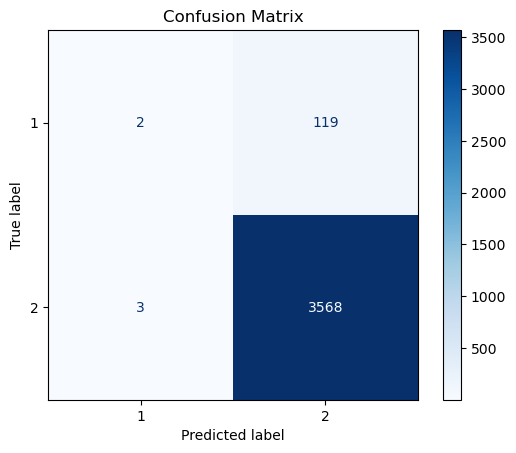

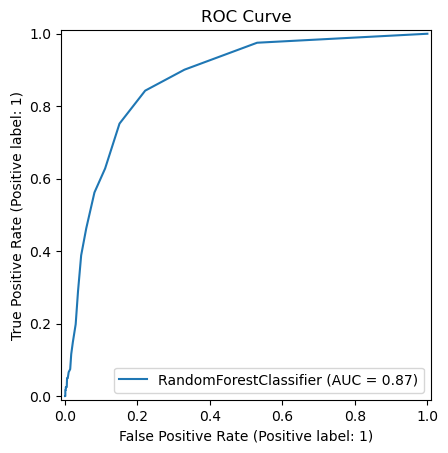

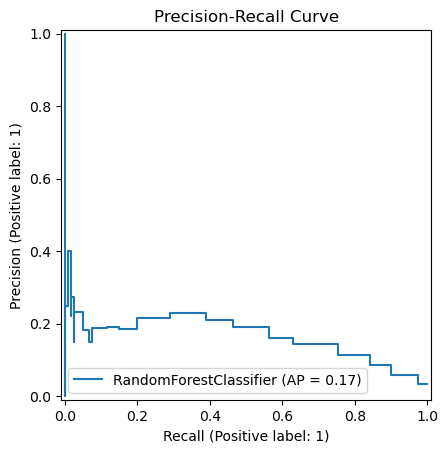

In [50]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced", n_jobs=-1)
rf_model.fit(df_transactions_11_44_binary_class_X_train, df_transactions_11_44_binary_class_y_train)

y_pred = rf_model.predict(df_transactions_45_49_X_test)
accuracy = accuracy_score(df_transactions_45_49_y_test, y_pred)
precision = precision_score(df_transactions_45_49_y_test, y_pred)
recall = recall_score(df_transactions_45_49_y_test, y_pred)
f1 = f1_score(df_transactions_45_49_y_test, y_pred)
print("Performance Metrics:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

cm = confusion_matrix(df_transactions_45_49_y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

disp = RocCurveDisplay.from_estimator(rf_model, df_transactions_45_49_X_test, df_transactions_45_49_y_test, pos_label=1)
plt.title("ROC Curve")
plt.show()

disp = PrecisionRecallDisplay.from_estimator(rf_model, df_transactions_45_49_X_test, df_transactions_45_49_y_test, pos_label=1)
plt.title("Precision-Recall Curve")
plt.show()

#### Use SMOTE for imbalance problem

In [36]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(df_transactions_11_44_binary_class_X_train.fillna(0), df_transactions_11_44_binary_class_y_train.fillna(0))
X_resampled.shape

(228116, 184)

#### Random Forrest with SMOTE

12
Performance Metrics:
Accuracy: 0.97
Precision: 0.33
Recall: 0.02
F1-Score: 0.03


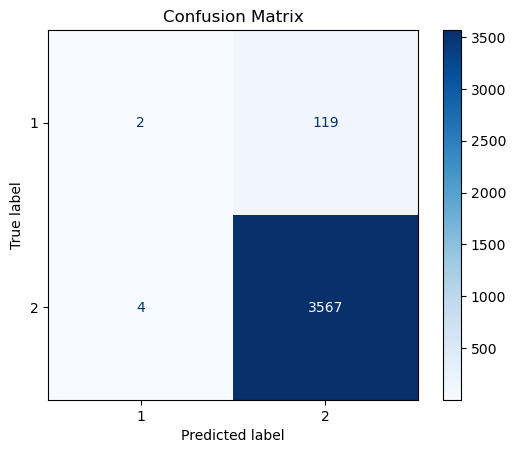

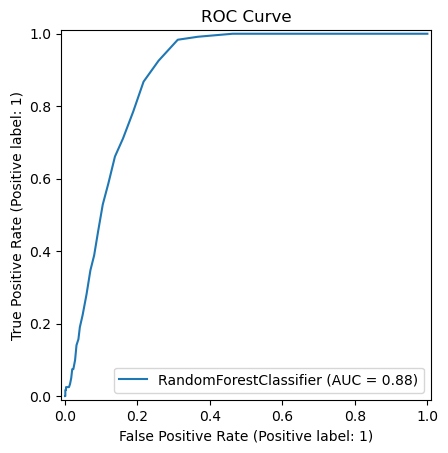

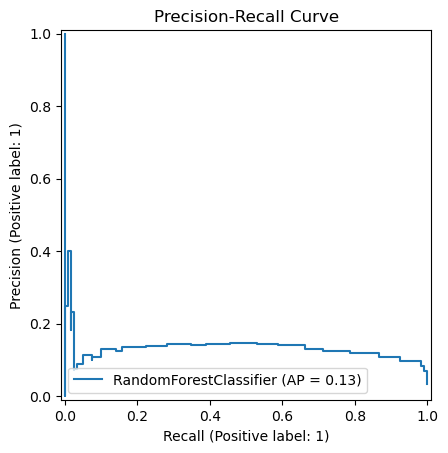

In [37]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=mp.cpu_count()-1)
rf_model.fit(X_resampled, y_resampled)

y_pred = rf_model.predict(df_transactions_45_49_X_test)
accuracy = accuracy_score(df_transactions_45_49_y_test, y_pred)
precision = precision_score(df_transactions_45_49_y_test, y_pred)
recall = recall_score(df_transactions_45_49_y_test, y_pred)
f1 = f1_score(df_transactions_45_49_y_test, y_pred)
print("Performance Metrics:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

cm = confusion_matrix(df_transactions_45_49_y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

disp = RocCurveDisplay.from_estimator(rf_model, df_transactions_45_49_X_test, df_transactions_45_49_y_test, pos_label=1)
plt.title("ROC Curve")
plt.show()

disp = PrecisionRecallDisplay.from_estimator(rf_model, df_transactions_45_49_X_test, df_transactions_45_49_y_test, pos_label=1)
plt.title("Precision-Recall Curve")
plt.show()

#### XGBOOST

Performance Metrics:
Accuracy: 0.97
Precision: 0.97
Recall: 1.00
F1-Score: 0.98


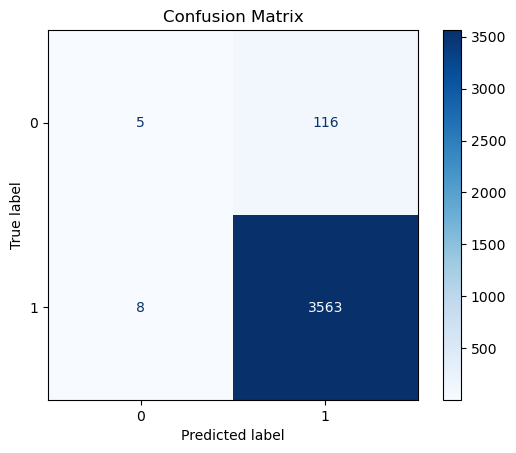

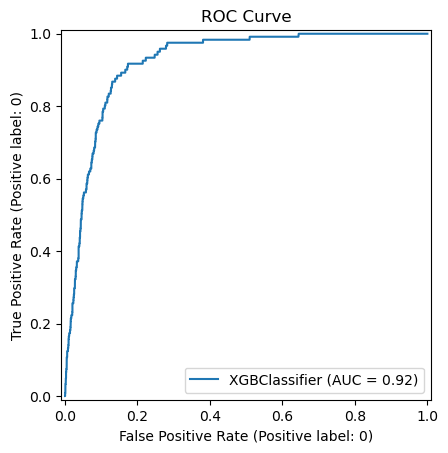

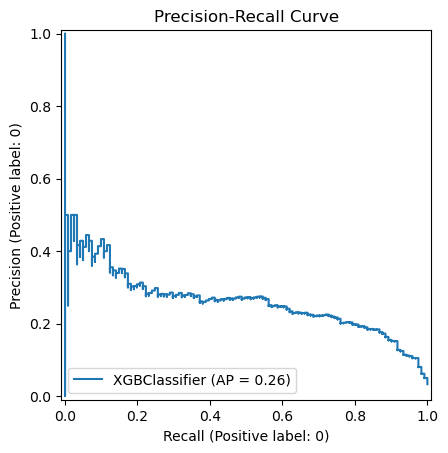

In [38]:
df_transactions_11_44_binary_y_train_xgb = df_transactions_11_44_binary_class_y_train.replace({1: 0, 2: 1})
df_transactions_45_49_y_test_xgb = df_transactions_45_49_y_test.replace({1: 0, 2: 1})

X_train = df_transactions_11_44_binary_class_X_train.fillna(0)
X_test = df_transactions_45_49_X_test.fillna(0)

xgb_model = XGBClassifier(n_estimators=100, random_state=42, n_jobs=mp.cpu_count()-1)
xgb_model.fit(X_train, df_transactions_11_44_binary_y_train_xgb)

y_pred = xgb_model.predict(X_test)
accuracy = accuracy_score(df_transactions_45_49_y_test_xgb, y_pred)
precision = precision_score(df_transactions_45_49_y_test_xgb, y_pred)
recall = recall_score(df_transactions_45_49_y_test_xgb, y_pred)
f1 = f1_score(df_transactions_45_49_y_test_xgb, y_pred)
print("Performance Metrics:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

cm = confusion_matrix(df_transactions_45_49_y_test_xgb, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_model.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

disp = RocCurveDisplay.from_estimator(xgb_model, X_test, df_transactions_45_49_y_test_xgb, pos_label=0)
plt.title("ROC Curve")
plt.show()

disp = PrecisionRecallDisplay.from_estimator(xgb_model, X_test, df_transactions_45_49_y_test_xgb, pos_label=0)
plt.title("Precision-Recall Curve")
plt.show()

In [39]:
# 1. Check class distribution in both sets
print("Training class distribution:")
print(np.bincount(df_transactions_11_44_binary_y_train_xgb))
print("\nTest class distribution:")
print(np.bincount(df_transactions_45_49_y_test_xgb))

# 2. Look at feature importance
importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_model.feature_importances_
})
print("\nTop 10 most important features:")
print(importances.sort_values('importance', ascending=False).head(10))

# 3. Check predictions distribution
print("\nPredictions distribution:")
print(np.bincount(y_pred))

# 4. Check feature overlap
print("\nSample of features ranges:")
print("Training min/max:", X_train.min().min(), X_train.max().max())
print("Test min/max:", X_test.min().min(), X_test.max().max())

Training class distribution:
[ 11182 114058]

Test class distribution:
[ 121 3571]

Top 10 most important features:
                  feature  importance
169                  size    0.270951
4         Local_feature_5    0.091475
40       Local_feature_41    0.070728
158  Aggregate_feature_66    0.031436
51       Local_feature_52    0.030906
30       Local_feature_31    0.018342
48       Local_feature_49    0.017741
162  Aggregate_feature_70    0.017269
52       Local_feature_53    0.016547
79       Local_feature_80    0.014784

Predictions distribution:
[  13 3679]

Sample of features ranges:
Training min/max: -13.09335839600819 166979.0
Test min/max: -13.09335839600819 156486.0


#### XGBOOST using SMOTE

Balanced Performance Metrics:
Balanced Accuracy: 0.58
Weighted Precision: 0.95
Weighted Recall: 0.93
Weighted F1-Score: 0.94

Class-specific metrics:
              precision    recall  f1-score   support

           0       0.15      0.21      0.17       121
           1       0.97      0.96      0.97      3571

    accuracy                           0.93      3692
   macro avg       0.56      0.58      0.57      3692
weighted avg       0.95      0.93      0.94      3692



<Figure size 800x600 with 0 Axes>

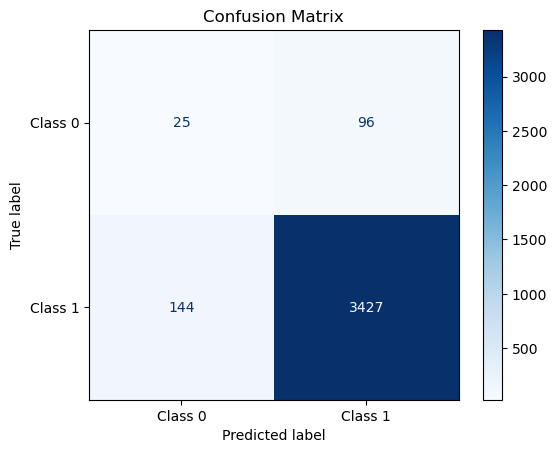

<Figure size 800x600 with 0 Axes>

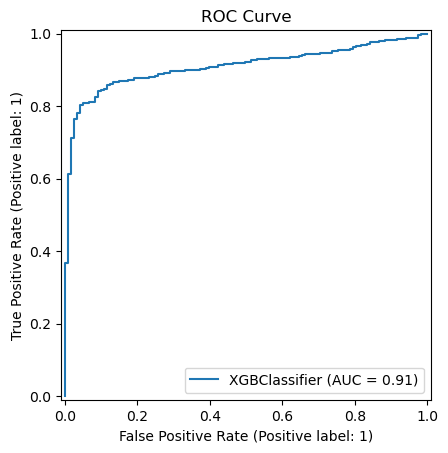

<Figure size 800x600 with 0 Axes>

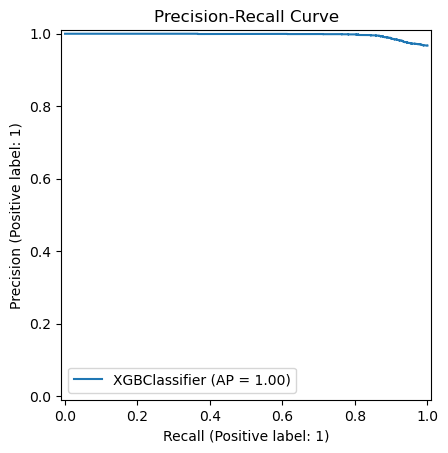

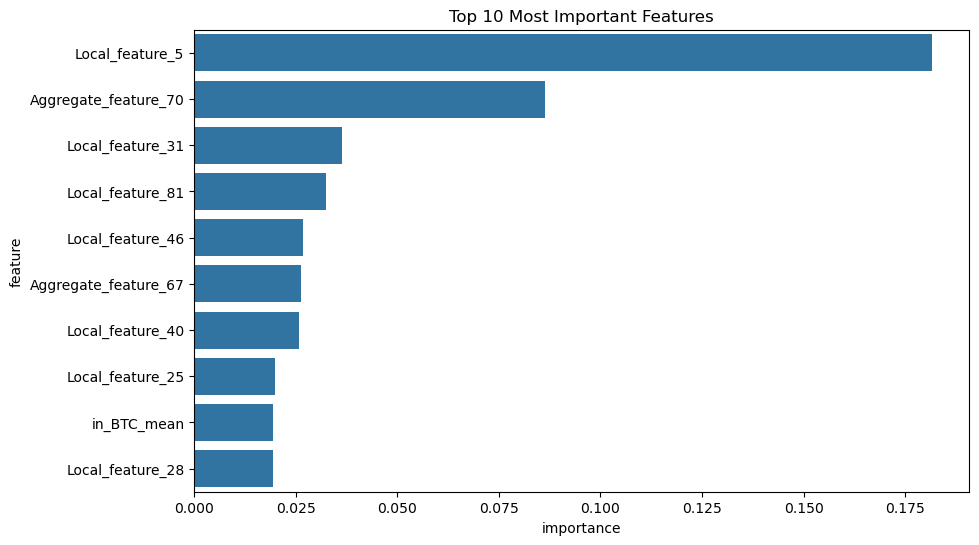

In [40]:
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, df_transactions_11_44_binary_y_train_xgb)

# Step 2: Create an improved XGBoost model with balanced settings
xgb_model_improved = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    min_child_weight=1,
    scale_pos_weight=len(df_transactions_11_44_binary_y_train_xgb[df_transactions_11_44_binary_y_train_xgb==0])/len(df_transactions_11_44_binary_y_train_xgb[df_transactions_11_44_binary_y_train_xgb==1]),  # Balance classes
    random_state=42,
    n_jobs=mp.cpu_count()-1
)
xgb_model_improved.fit(
    X_train_balanced, 
    y_train_balanced,
    verbose=True
)

y_pred_proba = xgb_model_improved.predict_proba(X_test)
y_pred = xgb_model_improved.predict(X_test)
balanced_accuracy = balanced_accuracy_score(df_transactions_45_49_y_test_xgb, y_pred)
precision = precision_score(df_transactions_45_49_y_test_xgb, y_pred, average='weighted')
recall = recall_score(df_transactions_45_49_y_test_xgb, y_pred, average='weighted')
f1 = f1_score(df_transactions_45_49_y_test_xgb, y_pred, average='weighted')
print("Balanced Performance Metrics:")
print(f"Balanced Accuracy: {balanced_accuracy:.2f}")
print(f"Weighted Precision: {precision:.2f}")
print(f"Weighted Recall: {recall:.2f}")
print(f"Weighted F1-Score: {f1:.2f}")

print("\nClass-specific metrics:")
print(classification_report(df_transactions_45_49_y_test_xgb, y_pred))

plt.figure(figsize=(8, 6))
cm = confusion_matrix(df_transactions_45_49_y_test_xgb, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

plt.figure(figsize=(8, 6))
RocCurveDisplay.from_estimator(xgb_model_improved, X_test, df_transactions_45_49_y_test_xgb)
plt.title("ROC Curve")
plt.show()

plt.figure(figsize=(8, 6))
PrecisionRecallDisplay.from_estimator(xgb_model_improved, X_test, df_transactions_45_49_y_test_xgb)
plt.title("Precision-Recall Curve")
plt.show()

# Step 10: Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_model_improved.feature_importances_
})
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.nlargest(10, 'importance'), 
            x='importance', y='feature')
plt.title('Top 10 Most Important Features')
plt.show()

#### SVC

In [41]:
svm_model = SVC(kernel='rbf', max_iter=5).fit(X_resampled, y_resampled)

svm_X_test = df_transactions_45_49_X_test.fillna(0)

y_pred = svm_model.predict(svm_X_test)
accuracy = accuracy_score(df_transactions_45_49_y_test, y_pred)
precision = precision_score(df_transactions_45_49_y_test, y_pred, average='weighted')
recall = recall_score(df_transactions_45_49_y_test, y_pred, average='weighted')
f1 = f1_score(df_transactions_45_49_y_test, y_pred, average='weighted')
print("Performance Metrics:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

cm = confusion_matrix(df_transactions_45_49_y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

plt.figure(figsize=(8, 6))
RocCurveDisplay.from_estimator(svm_model, svm_X_test, df_transactions_45_49_y_test)
plt.title("ROC Curve")
plt.show()

plt.figure(figsize=(8, 6))
PrecisionRecallDisplay.from_estimator(svm_model, svm_X_test, df_transactions_45_49_y_test)
plt.title("Precision-Recall Curve")
plt.show()

Performance Metrics:
Accuracy: 0.97
Precision: 0.94
Recall: 0.97
F1-Score: 0.95


#### Neural Nets

In [42]:
X_train_nn = df_transactions_11_44_binary_class_X_train.copy()
X_train_nn = X_train_nn.fillna(0)

In [43]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_nn)

print("Unique values in target:", np.unique(df_transactions_11_44_binary_class_y_train))
print("\nSample of target values:", df_transactions_11_44_binary_class_y_train[:10])

Unique values in target: [1 2]

Sample of target values: 0    2
1    2
2    2
3    2
4    2
5    2
6    2
7    2
8    2
9    2
Name: class, dtype: int64


In [44]:
print("\nShape of target:", df_transactions_11_44_binary_class_y_train.shape)
print("Shape of features:", X_train_scaled.shape)


Shape of target: (125240,)
Shape of features: (125240, 184)


In [ ]:
input_shape = X_train_scaled.shape[1]

X_train_scaled = np.clip(X_train_scaled, -10, 10)

NNmodel = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(input_shape,)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

NNmodel.summary()
NNmodel.input_shape
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0001
)
NNmodel.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)
history = NNmodel.fit(
    X_train_scaled,
    df_transactions_11_44_binary_class_y_train,
    epochs=100,
    batch_size=256,
    validation_split=0.2,
    verbose=1
)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 16)             │         2,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,249 (12.69 KB)

 Trainable params: 3,249 (12.69 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
392/392 ━━━━━━━━━━━━━━━━━━━━ 1s 558us/step - accuracy: 0.2853 - loss: 0.8717 - val_accuracy: 0.8318 - val_loss: 0.5479
Epoch 2/100
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - accuracy: 0.8474 - loss: 0.4944 - val_accuracy: 0.8959 - val_loss: 0.3470
Epoch 3/100
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - accuracy: 0.9078 - loss: 0.3203 - val_accuracy: 0.8980 - val_loss: 0.2529
Epoch 4/100
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - accuracy: 0.9185 - loss: 0.2425 - val_accuracy: 0.9026 - val_loss: 0.2134
Epoch 5/100
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step - accuracy: 0.9255 - loss: 0.2091 - val_accuracy: 0.9124 - val_loss: 0.1926
Epoch 6/100
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - accuracy: 0.9341 - loss: 0.1930 - val_accuracy: 0.9281 - val_loss: 0.1789
Epoch 7/100
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step - accuracy: 0.9393 - loss: 0.1846 - val_accuracy: 0.9409 - val_loss: 0.1673
Epoch 8/100
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step - accuracy: 0.9449 - loss: 0

In [46]:
X_test_nn = df_transactions_45_49_X_test.copy()
X_test_scaled = scaler.transform(X_test_nn)
X_test_scaled = np.clip(X_test_scaled, -10, 10)

predictions = NNmodel.predict(X_test_scaled)
binary_predictions = (predictions > 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(df_transactions_45_49_y_test, binary_predictions))
print("\nConfusion Matrix:")
print(confusion_matrix(df_transactions_45_49_y_test, binary_predictions))

116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 299us/step

Classification Report:
              precision    recall  f1-score   support

           1       0.03      1.00      0.06       121
           2       0.00      0.00      0.00      3571

    accuracy                           0.03      3692
   macro avg       0.02      0.50      0.03      3692
weighted avg       0.00      0.03      0.00      3692


Confusion Matrix:
[[ 121    0]
 [3571    0]]


#### Convolutional Neural Nets

In [47]:
X_train_cnn = df_transactions_11_44_binary_class_X_train.copy()
X_train_cnn = X_train_nn.fillna(0)

In [48]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_cnn)

print("Unique values in target:", np.unique(df_transactions_11_44_binary_class_y_train))
print("\nSample of target values:", df_transactions_11_44_binary_class_y_train[:10])

Unique values in target: [1 2]

Sample of target values: 0    2
1    2
2    2
3    2
4    2
5    2
6    2
7    2
8    2
9    2
Name: class, dtype: int64


In [49]:
print("\nShape of target:", df_transactions_11_44_binary_class_y_train.shape)
print("Shape of features:", X_train_scaled.shape)


Shape of target: (125240,)
Shape of features: (125240, 184)


In [75]:
input_shape = X_train_scaled.shape[1]

X_train_scaled = np.clip(X_train_scaled, -10, 10)

feature_dim = int(np.ceil(np.sqrt(input_shape)))
padding_needed = feature_dim * feature_dim - input_shape

X_train_reshaped = np.pad(X_train_scaled, ((0, 0), (0, padding_needed)))
X_train_reshaped = X_train_reshaped.reshape(-1, feature_dim, feature_dim, 1)

NNmodel = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(feature_dim, feature_dim, 1)),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

NNmodel.summary()
NNmodel.input_shape
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0001
)
NNmodel.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)
history = NNmodel.fit(
    X_train_reshaped,
    df_transactions_11_44_binary_class_y_train,
    epochs=100,
    batch_size=256,
    validation_split=0.2,
    verbose=1
)

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 12, 12, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 4, 4, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,129 (109.88 KB)

 Trainable params: 28,129 (109.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
392/392 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9027 - loss: 0.3878 - val_accuracy: 0.8951 - val_loss: 0.2258
Epoch 2/100
392/392 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9305 - loss: 0.2022 - val_accuracy: 0.9532 - val_loss: 0.1613
Epoch 3/100
392/392 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9566 - loss: 0.1608 - val_accuracy: 0.9572 - val_loss: 0.1417
Epoch 4/100
392/392 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9598 - loss: 0.1435 - val_accuracy: 0.9572 - val_loss: 0.1317
Epoch 5/100
392/392 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9616 - loss: 0.1302 - val_accuracy: 0.9605 - val_loss: 0.1233
Epoch 6/100
392/392 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9647 - loss: 0.1207 - val_accuracy: 0.9611 - val_loss: 0.1182
Epoch 7/100
392/392 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9659 - loss: 0.1135 - val_accuracy: 0.9636 - val_loss: 0.1138
Epoch 8/100
392/392 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9667 - loss: 0.1129 - val_accu

In [76]:
X_test_cnn = df_transactions_45_49_X_test.copy()
X_test_scaled = scaler.transform(X_test_cnn)
X_test_scaled = np.clip(X_test_scaled, -10, 10)

featrue_dim = int(np.ceil(np.sqrt(X_test_scaled.shape[1])))
padding_needed = feature_dim * feature_dim - X_test_scaled.shape[1]

X_test_reshaped = np.pad(X_test_scaled, ((0, 0), (0, padding_needed)))
X_test_reshaped = X_test_reshaped.reshape(-1, feature_dim, feature_dim, 1)

predictions = NNmodel.predict(X_test_reshaped)
binary_predictions = (predictions > 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(df_transactions_45_49_y_test, binary_predictions))
print("\nConfusion Matrix:")
print(confusion_matrix(df_transactions_45_49_y_test, binary_predictions))


116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step

Classification Report:
              precision    recall  f1-score   support

           0       0.09      0.02      0.04       121
           1       0.97      0.99      0.98      3571

    accuracy                           0.96      3692
   macro avg       0.53      0.51      0.51      3692
weighted avg       0.94      0.96      0.95      3692


Confusion Matrix:
[[   3  118]
 [  32 3539]]


#### Graph Neural Net

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
le = LabelEncoder()
df_transactions_11_44_binary_class_y_train = le.fit_transform(df_transactions_11_44_binary_class_y_train)
df_transactions_45_49_y_test = le.transform(df_transactions_45_49_y_test)

labels = torch.tensor(np.concatenate([df_transactions_11_44_binary_class_y_train, df_transactions_45_49_y_test], axis=0), dtype=torch.long)
features = torch.tensor(pd.concat([df_transactions_11_44_binary_class_X_train, df_transactions_45_49_X_test], axis=0).values, dtype=torch.float)
edge_index = torch.tensor(txs_edgelist[['txId1', 'txId2']].values.T, dtype=torch.long)

data = Data(x=features, edge_index=edge_index, y=labels)

In [ ]:
num_nodes = data.x.size(0)
mask = (data.edge_index[0] < num_nodes) & (data.edge_index[1] < num_nodes)
data.edge_index = data.edge_index[:, mask]

In [ ]:
train_size = df_transactions_11_44_binary_class_y_train.shape[0]
train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
train_mask[:train_size] = True
data.train_mask = train_mask

test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
test_mask[train_size:] = True
data.test_mask = test_mask

data = data.to(device)

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, 16)
        self.conv2 = GCNConv(16, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        x = torch.flatten(x, start_dim=1)
        return F.log_softmax(x, dim=1)

model = GCN(num_features=features.shape[1], num_classes=len(le.classes_))
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

# Training loop
model.train()
for epoch in range(100):
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

Epoch 1, Loss: 12.29541015625
Epoch 2, Loss: 9.63202953338623
Epoch 3, Loss: 8.225868225097656
Epoch 4, Loss: 7.219685077667236
Epoch 5, Loss: 6.204200267791748
Epoch 6, Loss: 5.5971503257751465
Epoch 7, Loss: 4.325491905212402
Epoch 8, Loss: 3.546074628829956
Epoch 9, Loss: 2.729382276535034
Epoch 10, Loss: 1.9417545795440674
Epoch 11, Loss: 1.4645085334777832
Epoch 12, Loss: 0.9976963996887207
Epoch 13, Loss: 0.7069379091262817
Epoch 14, Loss: 0.4907218813896179
Epoch 15, Loss: 0.4693438708782196
Epoch 16, Loss: 0.4886028468608856
Epoch 17, Loss: 0.5136968493461609
Epoch 18, Loss: 0.5455335974693298
Epoch 19, Loss: 0.5581032633781433
Epoch 20, Loss: 0.5658730268478394
Epoch 21, Loss: 0.5615437030792236
Epoch 22, Loss: 0.552450954914093
Epoch 23, Loss: 0.5411385893821716
Epoch 24, Loss: 0.5267342925071716
Epoch 25, Loss: 0.5262031555175781
Epoch 26, Loss: 0.5091701149940491
Epoch 27, Loss: 0.48798251152038574
Epoch 28, Loss: 0.4550896883010864
Epoch 29, Loss: 0.4356735944747925
Epoch 

In [61]:
# Evaluation
model.eval()
with torch.no_grad():
    out = model(data)
    pred = out.argmax(dim=1)
    acc = accuracy_score(data.y[data.test_mask].cpu(), pred[data.test_mask].cpu())
    print(f"Test Accuracy: {acc}")
    precision = precision_score(data.y[data.test_mask].cpu(), pred[data.test_mask].cpu(), average='weighted')
    recall = recall_score(data.y[data.test_mask].cpu(), pred[data.test_mask].cpu(), average='weighted')
    f1 = f1_score(data.y[data.test_mask].cpu(), pred[data.test_mask].cpu(), average='weighted')
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1-Score: {f1:.3f}")


Test Accuracy: 0.9672264355362947
Precision: 0.936
Recall: 0.967
F1-Score: 0.951


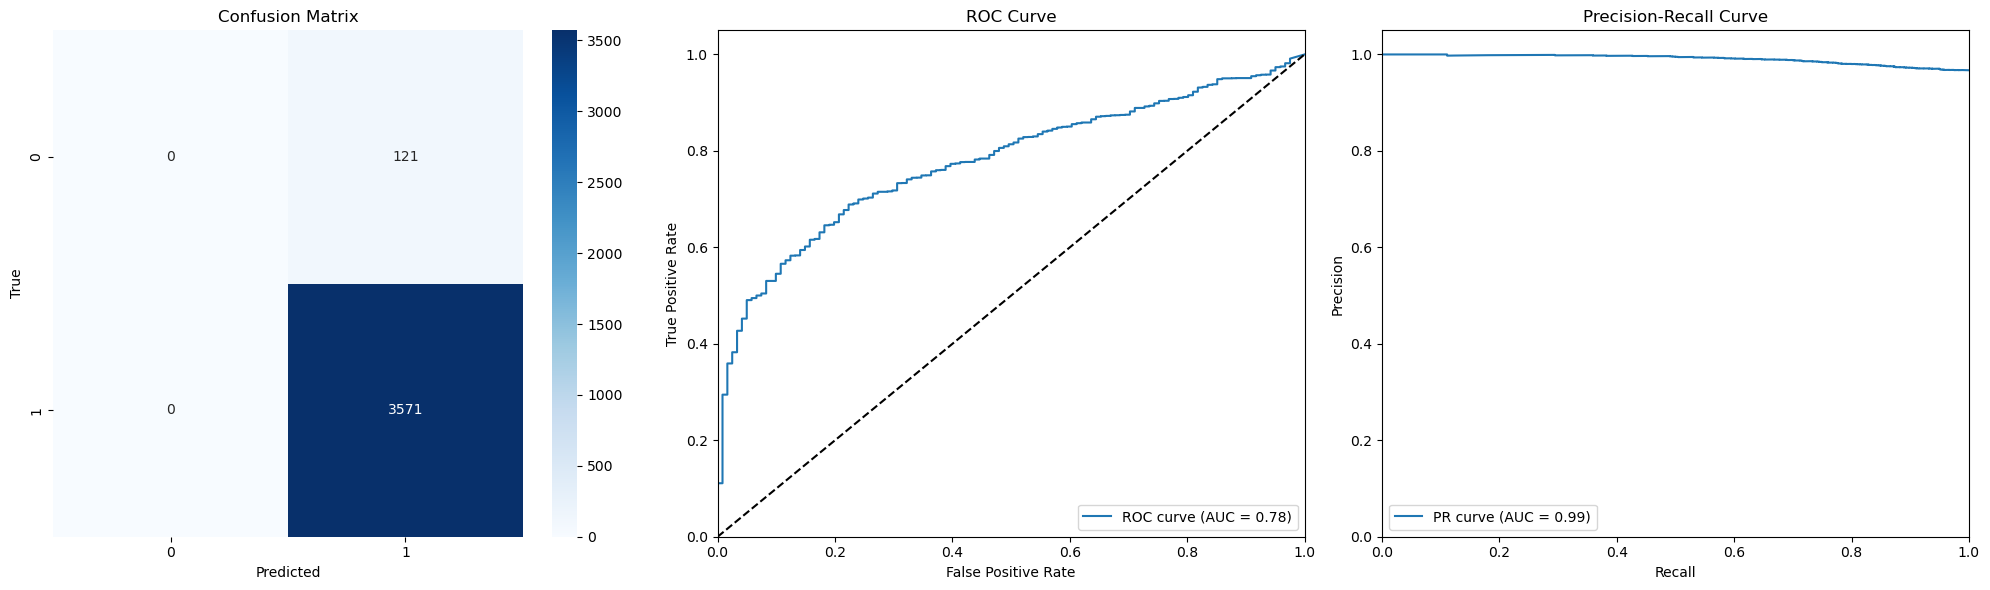

In [62]:
def plot_evaluation_metrics(y_true, y_pred, y_prob):
    """
    Create confusion matrix, ROC curve, and Precision-Recall curve plots
    
    Parameters:
    y_true: True labels
    y_pred: Predicted labels
    y_prob: Prediction probabilities for each class
    """
    # Convert tensors to numpy arrays if needed
    if hasattr(y_true, 'cpu'):
        y_true = y_true.cpu().numpy()
    if hasattr(y_pred, 'cpu'):
        y_pred = y_pred.cpu().numpy()
    if hasattr(y_prob, 'cpu'):
        y_prob = y_prob.cpu().numpy()
    
    # Get number of classes
    n_classes = y_prob.shape[1] if len(y_prob.shape) > 1 else 2
    
    # Create figure with subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
    
    # 1. Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1)
    ax1.set_title('Confusion Matrix')
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('True')
    
    # 2. ROC Curve
    if n_classes == 2:
        fpr, tpr, _ = roc_curve(y_true, y_prob[:, 1] if len(y_prob.shape) > 1 else y_prob)
        roc_auc = auc(fpr, tpr)
        ax2.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    else:
        # One-vs-Rest ROC curves for multiclass
        y_true_bin = label_binarize(y_true, classes=range(n_classes))
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
            roc_auc = auc(fpr, tpr)
            ax2.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')
    
    ax2.plot([0, 1], [0, 1], 'k--')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_title('ROC Curve')
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.legend(loc="lower right")
    
    # 3. Precision-Recall Curve
    if n_classes == 2:
        precision, recall, _ = precision_recall_curve(y_true, y_prob[:, 1] if len(y_prob.shape) > 1 else y_prob)
        pr_auc = auc(recall, precision)
        ax3.plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.2f})')
    else:
        # One-vs-Rest PR curves for multiclass
        for i in range(n_classes):
            precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_prob[:, i])
            pr_auc = auc(recall, precision)
            ax3.plot(recall, precision, label=f'Class {i} (AUC = {pr_auc:.2f})')
    
    ax3.set_xlim([0.0, 1.0])
    ax3.set_ylim([0.0, 1.05])
    ax3.set_title('Precision-Recall Curve')
    ax3.set_xlabel('Recall')
    ax3.set_ylabel('Precision')
    ax3.legend(loc="lower left")
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Usage example with your evaluation code:
model.eval()
with torch.no_grad():
    out = model(data)
    pred = out.argmax(dim=1)
    probs = torch.softmax(out, dim=1)
    
    # Get predictions and true labels for test set
    y_true = data.y[data.test_mask].cpu()
    y_pred = pred[data.test_mask].cpu()
    y_prob = probs[data.test_mask].cpu()
    
    # Create plots
    fig = plot_evaluation_metrics(y_true, y_pred, y_prob)